# Libraries

In [ ]:
from __future__ import print_function
import collections
import json
import math
import os
import sys
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
        from StringIO import StringIO  # Python 2.7
except ImportError:
        from io import BytesIO         # Python 3.x
print_grad = True


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Helper Functions (Printing, Logging, timing)

---



In [ ]:
print_grad = True

class printOut(object):
  def __init__(self,f=None ,stdout_print=True):
    self.out_file = f                #f is file for printing out results.
    self.stdout_print = stdout_print #true if we want to print.
  def print_out(self, s, new_line=True):
    """print but with support to flush and output to a file."""
    if isinstance(s, bytes):
      s = s.decode("utf-8")
    if self.out_file:
      self.out_file.write(s)
      if new_line:
        self.out_file.write("\n")
      self.out_file.flush()        
    if self.stdout_print:
      print(s, end="", file=sys.stdout)
      if new_line:
        sys.stdout.write("\n")
      sys.stdout.flush()
  def print_time(self,s,start_time):#prints the elapsed time duration and returns a new current time.
    #self.print_out("%s, time %ds, %s." % (s, (time.time() - start_time) +"  "+str(time.ctime())
    self.print_out(f"{s} time {time.time()-start_time}, {time.ctime()}")
    #use fstring above please.
    return time.time()
  def print_grad(self,model,last=False):
    if print_grad:
      for tag,value in model.named_parameters():
        if value.grad is not None:
          self.print_out('{0: <50}'.format(tag)+ "\t-- value:"+'%.12f'% value.norm().data[0]+"\t -- grad: "+ str(value.grad.norm().data[0]))
        else:
          self.print_out('{0: <50}'.format(tag)+ "\t-- value:" +'%.12f' % value.norm().data[0])
      self.print_out("-----------------------------------")
      if last:
        self.print_out("-----------------------------------")
        self.print_out("-----------------------------------")
        


In [ ]:
def to_np(x):
  return x.data.cpu().numpy()

In [ ]:
##why the f it is here, did not understand, we aren't even using pytorch!!
##do not run!!!
def to_vars(x):
  if torch.cuda.is_available():
    x = x.cuda()
  return Variable(x)

In [ ]:
def extract(xVar):
  global yGrad
  yGrad = xVar
  print(yGrad)

In [ ]:
def extract_norm(xVar):
  global yGrad
  yGradNorm = xVar.norm() 
  print(yGradNorm)

In [ ]:
#For tensorborad
#all are not used, just for helping in case we need it.
class logger(object):
  def __init__(self,log_dir):
    self.writer = tf.summary.FileWriter(log_dir)
  def scaler_summary(self,tag,value,step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
  def image_summary(self,tag,images,step):
    img_summaries = []
    for i, img in enumerate(images):
      try:
        s = StringIO()
      except:
        s = BytesIO()
      scipy.misc.toimage(img).save(s, format="png")
      img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),height=img.shape[0],width=img.shape[1])
      img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
  def histo_summary(self, tag, values, step, bins=1000):
    #logs histograms of the tensor values.
    counts, bin_edges = np.histogram(values, bins=bins)
    hist = tf.HistogramProto()
    hist.min = float(np.min(values))
    hist.max = float(np.max(values))
    hist.num = int(np.prod(values.shape))
    hist.sum = float(np.sum(values))
    hist.sum_squares = float(np.sum(values**2))
    # Drop the start of the first bin
    bin_edges = bin_edges[1:]
    # Add bin edges and counts
    for edge in bin_edges:
      hist.bucket_limit.append(edge)
    for c in counts:
      hist.bucket.append(c)
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
    self.writer.add_summary(summary, step)
    self.writer.flush()

In [ ]:
def add_summary(summary_writer, global_step, tag, value):
  #Add a new summary to the current summary_writer.
  summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
  summary_writer.add_summary(summary, global_step)

In [ ]:
def get_time():
  return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
def get_config_proto(log_device_placement=False, allow_soft_placement=True):
  # GPU options:
  # https://www.tensorflow.org/versions/r0.10/how_tos/using_gpu/index.html
  config_proto = tf.ConfigProto(
                  log_device_placement=log_device_placement,
                  allow_soft_placement=allow_soft_placement)
  config_proto.gpu_options.allow_growth = True
  return config_proto

In [ ]:
def debug_tensor(s,msg=None,summarize=10):
  #to print the shape of the tensor
  if not msg:
    msg = s.name
  return tf.Print(s, [tf.shape(s), s], msg + " ", summarize=summarize)

In [ ]:
def has_nan(datum, tensor):
  if hasattr(tensor, 'dtype'):
    if (np.issubdtype(tensor.dtype, np.float) or np.issubdtype(tensor.dtype, np.complex) or np.issubdtype(tensor.dtype, np.integer)):
      return np.any(np.isnan(tensor))
    else:
      return False
  else:
    return False

def openAI_entropy(logits):
  # Entropy proposed by OpenAI in their A2C baseline
  a0 = logits - tf.reduce_max(logits, 2, keepdims=True)
  ea0 = tf.exp(a0)
  z0 = tf.reduce_sum(ea0, 2, keepdims=True)
  p0 = ea0 / z0
  return tf.reduce_mean(tf.reduce_sum(p0 * (tf.math.log(z0) - a0), 2))


def softmax_entropy(p0):
  # Normal information theory entropy by Shannon
  return - tf.reduce_sum(p0 * tf.math.log(p0 + 1e-6), axis=1)

def Dist_mat(A):
# A is of shape [batch_size x nnodes x 2].
# return: a distance matrix with shape [batch_size x nnodes x nnodes]
  nnodes = tf.shape(A)[1]
  A1 = tf.tile(tf.expand_dims(A,1),[1,nnodes,1,1])
  A2 = tf.tile(tf.expand_dims(A,2),[1,1,nnodes,1])
  dist = tf.norm(A1-A2,axis=3)
  return dist

In [ ]:
def gradient_clip(gradients, params, max_gradient_norm):
  """Clipping gradients of a model."""
  clipped_gradients, gradient_norm = tf.clip_by_global_norm(gradients, max_gradient_norm)
  gradient_norm_summary = [tf.summary.scalar("grad_norm", gradient_norm)]
  gradient_norm_summary.append(tf.summary.scalar("clipped_gradient", tf.global_norm(clipped_gradients)))
  return clipped_gradients, gradient_norm_summary

In [ ]:
def create_or_load_model(model, model_dir, session, out_dir, name):
  """Create translation model and initialize or load parameters in session."""
  start_time = time.time()
  latest_ckpt = tf.train.latest_checkpoint(model_dir)
  if latest_ckpt:
    model.saver.restore(session, latest_ckpt)
    utils.print_out("  loaded %s model parameters from %s, time %.2fs" %(name, latest_ckpt, time.time() - start_time))
  else:
    utils.print_out("  created %s model with fresh parameters, time %.2fs." %(name, time.time() - start_time))
    session.run(tf.global_variables_initializer())
  global_step = model.global_step.eval(session=session)
  return model, global_step

In [ ]:
def get_config_proto(log_device_placement=False, allow_soft_placement=True):
  # GPU options:
  # https://www.tensorflow.org/versions/r0.10/how_tos/using_gpu/index.html
  config_proto = tf.ConfigProto(log_device_placement=log_device_placement,allow_soft_placement=allow_soft_placement)
  config_proto.gpu_options.allow_growth = True
  return config_proto

In [ ]:
def check_tensorflow_version():
  if tf.__version__ < "1.2.1":
    raise EnvironmentError("Tensorflow version must >= 1.2.1")

In [ ]:
def debug_tensor(s, msg=None, summarize=10):
  """Print the shape and value of a tensor at test time. Return a new tensor."""
  if not msg:
    msg = s.name
  return tf.Print(s, [tf.shape(s), s], msg + " ", summarize=summarize)

In [ ]:
def tf_print(tensor, transform=None):
  # Insert a custom python operation into the graph that does nothing but print a tensors value 
  def print_tensor(x):
    # x is typically a numpy array here so you could do anything you want with it,
    # but adding a transformation of some kind usually makes the output more digestible
    print(x if transform is None else transform(x))
    return x
  log_op = tf.py_func(print_tensor, [tensor], [tensor.dtype])[0]
  with tf.control_dependencies([log_op]):
    res = tf.identity(tensor)
  # Return the given tensor
  return res


# configs

In [ ]:
from collections import namedtuple

TaskVRP = namedtuple('TaskVRP', ['task_name', 
						'input_dim',
						'n_nodes' ,
						'n_cust',
						'decode_len',
						'capacity',
						'demand_max'])


task_lst = {}

# VRP10
vrp10 = TaskVRP(task_name = 'vrp',
			  input_dim=3,
			  n_nodes=11,
			  n_cust = 10,
			  decode_len=16,
			  capacity=20,
			  demand_max=9)
task_lst['vrp10'] = vrp10

# VRP20
vrp20 = TaskVRP(task_name = 'vrp',
			  input_dim=3,
			  n_nodes=21,
			  n_cust = 20,
			  decode_len=30,
			  capacity=30,
			  demand_max=9)
task_lst['vrp20'] = vrp20

In [ ]:
#import shared.misc_utils as utils

def str2bool(v):
  return v.lower() in ('true', '1')

def initialize_task_settings(args,task):

  try:
      task_params = task_lst[task]
  except:
      raise Exception('Task is not implemented.') 

  for name, value in task_params._asdict().items():
    args[name] = value


  return args

def ParseParams():
  parser = argparse.ArgumentParser(description="Neural Combinatorial Optimization with RL")

  # Data
  parser.add_argument('--task', default='vrp20', help="Select the task to solve; i.e. tsp10")
  parser.add_argument('--batch_size', default=128,type=int, help='Batch size in training')
  parser.add_argument('--n_train', default=26000,type=int, help='Number of training steps')
  parser.add_argument('--test_size', default=20,type=int, help='Number of problems in test set')

  # Network
  parser.add_argument('--agent_type', default='attention', help="attention|pointer")
  parser.add_argument('--forget_bias', default=1.0,type=float, help="Forget bias for BasicLSTMCell.")
  parser.add_argument('--embedding_dim', default=128,type=int, help='Dimension of input embedding')
  parser.add_argument('--hidden_dim', default=128,type=int, help='Dimension of hidden layers in Enc/Dec')
  parser.add_argument('--n_process_blocks', default=3,type=int,                     
                      help='Number of process block iters to run in the Critic network')
  parser.add_argument('--rnn_layers', default=1, type=int, help='Number of LSTM layers in the encoder and decoder')
  parser.add_argument('--decode_len', default=None,type=int,                     
                      help='Number of time steps the decoder runs before stopping')
  parser.add_argument('--n_glimpses', default=0, type=int, help='Number of glimpses to use in the attention')
  parser.add_argument('--tanh_exploration', default=10.,  type=float,                   
            help='Hyperparam controlling exploration in the net by scaling the tanh in the softmax')
  parser.add_argument('--use_tanh', type=str2bool, default=False, help='')
  parser.add_argument('--mask_glimpses', type=str2bool, default=True, help='')
  parser.add_argument('--mask_pointer', type=str2bool, default=True, help='')
  parser.add_argument('--dropout', default=0.1, type=float, help='The dropout prob')

  # Training
  #is train is here
  parser.add_argument('--is_train', default=False,type=str2bool, help="whether to do the training or not")
  parser.add_argument('--actor_net_lr', default=1e-4,type=float, help="Set the learning rate for the actor network")
  parser.add_argument('--critic_net_lr', default=1e-4,type=float, help="Set the learning rate for the critic network")
  parser.add_argument('--random_seed', default=24601,type=int, help='')
  parser.add_argument('--max_grad_norm', default=2.0, type=float, help='Gradient clipping')
  parser.add_argument('--entropy_coeff', default=0.1, type=float, help='coefficient for entropy regularization')
  # parser.add_argument('--loss_type', type=int, default=1, help='1,2,3')

  # inference
  parser.add_argument('--infer_type', default='batch', 
      help='single|batch: do inference for the problems one-by-one, or run it all at once')
  parser.add_argument('--beam_width', default=10, type=int, help='')

  # Misc
  parser.add_argument('--stdout_print', default=True, type=str2bool, help='print control')
  parser.add_argument("--gpu", default='1', type=str,help="gpu number.")
  parser.add_argument('--log_interval', default=200,type=int, help='Log info every log_step steps')
  parser.add_argument('--test_interval', default=200,type=int, help='test every test_interval steps')
  parser.add_argument('--save_interval', default=2000,type=int, help='save every save_interval steps')
  parser.add_argument('--log_dir', type=str, default='logs')
  parser.add_argument('--data_dir', type=str, default='data')
  parser.add_argument('--model_dir', type=str, default='logs/vrp10-2021-11-22_04-20-42/model')
  parser.add_argument('--load_path', type=str, default='', help='Path to load trained variables')
  parser.add_argument('--disable_tqdm', default=True, type=str2bool)
                      
  args, unknown = parser.parse_known_args()
  args = vars(args)

  args['log_dir'] = "{}/{}-{}".format(args['log_dir'],args['task'], get_time())
  if args['model_dir'] =='':
      args['model_dir'] = os.path.join(args['log_dir'],'model')

  # file to write the stdout
  try:
      os.makedirs(args['log_dir'])
      os.makedirs(args['model_dir'])
  except:
      pass

  # create a print handler
  out_file = open(os.path.join(args['log_dir'], 'results.txt'),'w+') 
  prt = printOut(out_file,args['stdout_print'])

  os.environ["CUDA_VISIBLE_DEVICES"]=  args['gpu'] 

  args = initialize_task_settings(args,args['task'])

  # print the run args
  for key, value in sorted(args.items()):
      prt.print_out("{}: {}".format(key,value))

  return args, prt


#Creating embeddings

---

In [ ]:
class Embedding(object):
  '''This class is the base class for embedding the input graph.'''
  def __init__(self,emb_type, embedding_dim):
    self.emb_type = emb_type
    self.embedding_dim = embedding_dim

  def __call__(self,input_pnt):
    # returns the embeded tensor. Should be implemented in child classes
    pass

In [ ]:
class LinearEmbedding(Embedding):
  #this class gives us embeddings of the input
  def __init__(self,embedding_dim,_scope=''):
    super(LinearEmbedding,self).__init__('linear',embedding_dim)#default embedding_dim = 128
    self.project_emd = tf.keras.layers.Conv1D(embedding_dim,1)
  def __call__(self,input_pnt):
    emb_inp_pnt = self.project_emd(input_pnt)
    return emb_inp_pnt

# Decoder classes

---



In [ ]:
class DecodeStep(object):
  #base class of the decoder.
  def __init__(self, ClAttention,hidden_dim,use_tanh=False,tanh_exploration=10.,n_glimpses=0,mask_glimpses=True,mask_pointer=True,_scope=''):

    self.hidden_dim = hidden_dim
    self.use_tanh = use_tanh
    self.tanh_exploration = tanh_exploration
    self.n_glimpses = n_glimpses
    self.mask_glimpses = mask_glimpses
    self.mask_pointer = mask_pointer
    self._scope = _scope
    self.BIGNUMBER = 100000.
    self.glimpses = [None for _ in range(self.n_glimpses)]
    for i in range(self.n_glimpses):
      self.glimpses[i] = ClAttention(hidden_dim,use_tanh=False,_scope=self._scope,_name="Glimpse"+str(i))
    self.pointer = ClAttention(hidden_dim,use_tanh=use_tanh,C=tanh_exploration,_scope=self._scope,_name="Decoder/Attention")
  def get_logit_op(self,decoder_inp,context,Env,*args,**kwargs):
    for i in range(self.n_glimpses):
      ref, logit = self.glimpses[i](decoder_inp, context,Env)
      if self.mask_glimpses:
        logit -= self.BIGNUMBER* Env.mask
      # prob: [batch_size x max_time]
      prob = tf.nn.softmax(logit)
      # decoder_inp : [batch_size x 1 x max_time ] * [batch_size x max_time x hidden_dim] -> [batch_size x hidden_dim ]
      decoder_inp = tf.squeeze(tf.matmul( tf.expand_dims(prob,1),ref) ,1)
    _,logit = self.pointer(decoder_inp,context,Env)
    if self.mask_pointer:
      logit-=self.BIGNUMBER*Env.mask
    return logit, None
  def step(self,decoder_inp,context,Env,decoder_state=None,*args,**kwargs):
    logit, decoder_state = self.get_logit_op(decoder_inp,context,Env,decoder_state)
    logprob = tf.nn.log_softmax(logit)
    prob = tf.exp(logprob)
    return logit, prob, logprob, decoder_state

In [ ]:
class RNNDecodeStep(DecodeStep):
  #Decodes the sequence. It keeps the decoding history in a RNN.
  def __init__(self,ClAttention,hidden_dim,use_tanh=False,tanh_exploration=10.,n_glimpses=0,mask_glimpses=True,mask_pointer=True,forget_bias=1.0,rnn_layers=1,_scope=''):

    super(RNNDecodeStep,self).__init__(ClAttention,hidden_dim,use_tanh=use_tanh,tanh_exploration=tanh_exploration,n_glimpses=n_glimpses,mask_glimpses=mask_glimpses,mask_pointer=mask_pointer,_scope=_scope)
    self.forget_bias = forget_bias
    self.rnn_layers = rnn_layers
    single_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(hidden_dim,forget_bias=forget_bias)
    self.dropout = tf.compat.v1.placeholder(tf.float32,name='decoder_rnn_dropout') 
    single_cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell=single_cell, input_keep_prob=(1.0 - self.dropout))
    self.cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([single_cell] * rnn_layers)
  def get_logit_op(self,decoder_inp,context,Env,decoder_state,*args,**kwargs):
    _ , decoder_state = tf.compat.v1.nn.dynamic_rnn(self.cell,decoder_inp,initial_state=decoder_state,scope=self._scope+'Decoder/LSTM/rnn')
    hy = decoder_state[-1].h
    # glimpses
    for i in range(self.n_glimpses):
      ref, logit = self.glimpses[i](hy,context,Env)
      if self.mask_glimpses:
        logit -= self.BIGNUMBER* Env.mask
      prob = tf.nn.softmax(logit)
      hy = tf.squeeze(tf.matmul( tf.expand_dims(prob,1),ref) ,1)
    _, logit = self.pointer(hy,context,Env)
    if self.mask_pointer:
      logit -= self.BIGNUMBER* Env.mask
      return logit, decoder_state

# Attention

---



In [ ]:
class Attention(object):
  def __init__(self,dim,use_tanh=False,C=10,_name='Attention',_scope=''):
    self.use_tanh = use_tanh
    self._scope = _scope
    with tf.compat.v1.variable_scope(_scope+_name):
      # self.v: is a variable with shape [1 x dim]
      self.v = tf.compat.v1.get_variable('v',[1,dim],initializer=tf.compat.v1.keras.initializers.glorot_normal())
      self.v = tf.expand_dims(self.v,2)
    self.project_query = tf.keras.layers.Dense(dim,_scope=_scope+_name+'/dense')
    self.project_ref = tf.keras.layers.Conv1D(dim,1,_scope=_scope+_name +'/conv1d')
    self.C = C  # tanh exploration parameter
    self.tanh = tf.nn.tanh

  def __call__(self,query,ref,*args,**kwargs):
    #query: is the hidden state of the decoder at the current time step. [batch_size x dim]
    #ref: the set of hidden states from the encoder.[batch_size x max_time x dim]
    #e: convolved ref with shape [batch_size x max_time x dim]
    #logits: [batch_size x max_time]
    e = self.project_ref(ref)
    q = self.project_query(query) #[batch_size x dim]
    expanded_q = tf.tile(tf.expand_dims(q,1),[1,tf.shape(e)[1],1])
    v_view = tf.tile( self.v, [tf.shape(e)[0],1,1]) # v_view:[batch_size x dim x 1]
    u = tf.squeeze(tf.matmul(self.tanh(expanded_q + e), v_view),2)# u : [batch_size x max_time x dim] * [batch_size x dim x 1] = [batch_size x max_time]
    if self.use_tanh:
      logits = self.C * self.tanh(u)
    else:
      logits = u
    return e,logits


# VRP Util

In [ ]:
def create_VRP_dataset(
      n_problems,
      n_cust,
      data_dir,
      seed=None,
      data_type='train'):

  n_nodes = n_cust +1
  if seed == None:
      rnd = np.random
  else:
      rnd = np.random.RandomState(seed)
  
  # build task name and datafiles
  task_name = 'vrp-size-{}-len-{}-{}.txt'.format(n_problems, n_nodes,data_type)
  fname = os.path.join(data_dir, task_name)

  # cteate/load data
  if os.path.exists(fname):
      print('Loading dataset for {}...'.format(task_name))
      data = np.loadtxt(fname,delimiter=' ')
      data = data.reshape(-1, n_nodes,3)
  else:
      print('Creating dataset for {}...'.format(task_name))
      # Generate a training set of size n_problems 
      x = rnd.uniform(0,1,size=(n_problems,n_nodes,2))
      d = rnd.randint(1,10,[n_problems,n_nodes,1])
      d[:,-1]=0 # demand of depot
      data = np.concatenate([x,d],2)
      np.savetxt(fname, data.reshape(-1, n_nodes*3))

  return data

class DataGenerator(object):
  def __init__(self, 
                args):


      self.args = args
      self.rnd = np.random.RandomState(seed= args['random_seed'])
      print('Created train iterator.')

      # create test data
      self.n_problems = args['test_size']
      self.test_data = create_VRP_dataset(self.n_problems,args['n_cust'],'./data',
          seed = args['random_seed']+1,data_type='test')

      self.reset()

  def reset(self):
      self.count = 0

  def get_train_next(self):
      '''
      Get next batch of problems for training
      Retuens:
          input_data: data with shape [batch_size x max_time x 3]
      '''

      input_pnt = self.rnd.uniform(0,1,
          size=(self.args['batch_size'],self.args['n_nodes'],2))

      demand = self.rnd.randint(1,10,[self.args['batch_size'],self.args['n_nodes']])
      demand[:,-1]=0 # demand of depot

      input_data = np.concatenate([input_pnt,np.expand_dims(demand,2)],2)

      return input_data


  def get_test_next(self):
      '''
      Get next batch of problems for testing
      '''
      if self.count<self.args['test_size']:
          input_pnt = self.test_data[self.count:self.count+1]
          self.count +=1
      else:
          warnings.warn("The test iterator reset.") 
          self.count = 0
          input_pnt = self.test_data[self.count:self.count+1]
          self.count +=1

      return input_pnt

  def get_test_all(self):
      '''
      Get all test problems
      '''
      return self.test_data
  

class State(collections.namedtuple("State",
                                   ("load",
                                   "demand",
                                   'd_sat',
                                   "mask"))):
  pass
  
class Env(object):
  def __init__(self,
                args):
      '''
      This is the environment for VRP.
      Inputs: 
          args: the parameter dictionary. It should include:
              args['n_nodes']: number of nodes in VRP
              args['n_custs']: number of customers in VRP
              args['input_dim']: dimension of the problem which is 2
      '''
      self.capacity = args['capacity']
      self.n_nodes = args['n_nodes']
      self.n_cust = args['n_cust']
      self.input_dim = args['input_dim']
      self.input_data = tf.compat.v1.placeholder(tf.float32,\
          shape=[None,self.n_nodes,self.input_dim])

      self.input_pnt = self.input_data[:,:,:2]
      self.demand = self.input_data[:,:,-1]
      self.batch_size = tf.shape(self.input_pnt)[0] 
      
  def reset(self,beam_width=1):

      # dimensions
      self.beam_width = beam_width
      self.batch_beam = self.batch_size * beam_width

      self.input_pnt = self.input_data[:,:,:2]
      self.demand = self.input_data[:,:,-1]

      self.demand = tf.tile(self.demand, [self.beam_width,1])

      # load: [batch_size * beam_width]
      self.load = tf.ones([self.batch_beam])*self.capacity

      # create mask
      self.mask = tf.zeros([self.batch_size*beam_width,self.n_nodes],
              dtype=tf.float32)

      # update mask -- mask if customer demand is 0 and depot
      self.mask = tf.concat([tf.cast(tf.equal(self.demand,0), tf.float32)[:,:-1],
          tf.ones([self.batch_beam,1])],1)

      state = State(load=self.load,
                  demand = self.demand,
                  d_sat = tf.zeros([self.batch_beam,self.n_nodes]),
                  mask = self.mask )

      return state

  def step(self,
            idx,
            beam_parent=None):
      '''
      runs one step of the environment and updates demands, loads and masks
      '''

      # if the environment is used in beam search decoder
      if beam_parent is not None:
          # BatchBeamSeq: [batch_size*beam_width x 1]
          # [0,1,2,3,...,127,0,1,...],
          batchBeamSeq = tf.expand_dims(tf.tile(tf.cast(tf.range(self.batch_size), tf.int64),
                                                [self.beam_width]),1)
          # batchedBeamIdx:[batch_size*beam_width]
          batchedBeamIdx= batchBeamSeq + tf.cast(self.batch_size,tf.int64)*beam_parent
          # demand:[batch_size*beam_width x sourceL]
          self.demand= tf.gather_nd(self.demand,batchedBeamIdx)
          #load:[batch_size*beam_width]
          self.load = tf.gather_nd(self.load,batchedBeamIdx)
          #MASK:[batch_size*beam_width x sourceL]
          self.mask = tf.gather_nd(self.mask,batchedBeamIdx)


      BatchSequence = tf.expand_dims(tf.cast(tf.range(self.batch_beam), tf.int64), 1)
      batched_idx = tf.concat([BatchSequence,idx],1)

      # how much the demand is satisfied
      d_sat = tf.minimum(tf.gather_nd(self.demand,batched_idx), self.load)

      # update the demand
      d_scatter = tf.scatter_nd(batched_idx, d_sat, tf.cast(tf.shape(self.demand),tf.int64))
      self.demand = tf.subtract(self.demand, d_scatter)

      # update load
      self.load -= d_sat

      # refill the truck -- idx: [10,9,10] -> load_flag: [1 0 1]
      load_flag = tf.squeeze(tf.cast(tf.equal(idx,self.n_cust),tf.float32),1)
      self.load = tf.multiply(self.load,1-load_flag) + load_flag *self.capacity

      # mask for customers with zero demand
      self.mask = tf.concat([tf.cast(tf.equal(self.demand,0), tf.float32)[:,:-1],
                                        tf.zeros([self.batch_beam,1])],1)

      # mask if load= 0 
      # mask if in depot and there is still a demand

      self.mask += tf.concat( [tf.tile(tf.expand_dims(tf.cast(tf.equal(self.load,0),
          tf.float32),1), [1,self.n_cust]),                      
          tf.expand_dims(tf.multiply(tf.cast(tf.greater(tf.reduce_sum(self.demand,1),0),tf.float32),
                            tf.squeeze( tf.cast(tf.equal(idx,self.n_cust),tf.float32))),1)],1)

      state = State(load=self.load,
                  demand = self.demand,
                  d_sat = d_sat,
                  mask = self.mask )

      return state

def reward_func(sample_solution):



  # make sample_solution of shape [sourceL x batch_size x input_dim]
  sample_solution = tf.stack(sample_solution,0)

  sample_solution_tilted = tf.concat((tf.expand_dims(sample_solution[-1],0),
        sample_solution[:-1]),0)
  # get the reward based on the route lengths


  route_lens_decoded = tf.reduce_sum(tf.pow(tf.reduce_sum(tf.pow(\
      (sample_solution_tilted - sample_solution) ,2), 2) , .5), 0)
  return route_lens_decoded 

# VRP Attention

In [ ]:
class AttentionVRPActor(object):
  """A generic attention module for the attention in vrp model"""
  def __init__(self, dim, use_tanh=False, C=10,_name='Attention',_scope=''):
      self.use_tanh = use_tanh
      self._scope = _scope

      with tf.compat.v1.variable_scope(_scope+_name):
          # self.v: is a variable with shape [1 x dim]
          self.v = tf.compat.v1.get_variable('v',[1,dim],
                      initializer=tf.compat.v1.keras.initializers.glorot_normal())
          self.v = tf.expand_dims(self.v,2)
          
      self.emb_d = tf.keras.layers.Conv1D(dim,1) #conv1d
      self.emb_ld = tf.keras.layers.Conv1D(dim,1) #conv1d_2

      self.project_d = tf.keras.layers.Conv1D(dim,1) #conv1d_1
      self.project_ld = tf.keras.layers.Conv1D(dim,1) #conv1d_3
      self.project_query = tf.keras.layers.Dense(dim) #
      self.project_ref = tf.keras.layers.Conv1D(dim,1) #conv1d_4


      self.C = C  # tanh exploration parameter
      self.tanh = tf.nn.tanh

  def __call__(self, query, ref, env):

      demand = env.demand
      load = env.load
      max_time = tf.shape(demand)[1]

      emb_d = self.emb_d(tf.expand_dims(demand,2))
      # d:[batch_size x max_time x dim ]
      d = self.project_d(emb_d)

      emb_ld = self.emb_ld(tf.expand_dims(tf.tile(tf.expand_dims(load,1),[1,max_time])-
                                            demand,2))
      # ld:[batch_size*beam_width x hidden_dim x max_time ] 
      ld = self.project_ld(emb_ld)

      # expanded_q,e: [batch_size x max_time x dim]
      e = self.project_ref(ref)
      q = self.project_query(query) #[batch_size x dim]
      expanded_q = tf.tile(tf.expand_dims(q,1),[1,max_time,1])

      # v_view:[batch_size x dim x 1]
      v_view = tf.tile( self.v, [tf.shape(e)[0],1,1]) 
      
      u = tf.squeeze(tf.matmul(self.tanh(expanded_q + e + d + ld), v_view),2)

      if self.use_tanh:
          logits = self.C * self.tanh(u)
      else:
          logits = u  

      return e, logits


class AttentionVRPCritic(object):
  def __init__(self, dim, use_tanh=False, C=10,_name='Attention',_scope=''):

      self.use_tanh = use_tanh
      self._scope = _scope

      with tf.compat.v1.variable_scope(_scope+_name):
          # self.v: is a variable with shape [1 x dim]
          self.v = tf.compat.v1.get_variable('v',[1,dim],
                      initializer=tf.compat.v1.keras.initializers.glorot_normal())
          self.v = tf.expand_dims(self.v,2)
          
      self.emb_d = tf.keras.layers.Conv1D(dim,1) #conv1d
      self.project_d = tf.keras.layers.Conv1D(dim,1) #conv1d_1
      
      self.project_query = tf.keras.layers.Dense(dim) #
      self.project_ref = tf.keras.layers.Conv1D(dim,1) #conv1d_2

      self.C = C  # tanh exploration parameter
      self.tanh = tf.nn.tanh
      
  def __call__(self, query, ref, env):

      demand = env.input_data[:,:,-1]
      max_time = tf.shape(demand)[1]

      emb_d = self.emb_d(tf.expand_dims(demand,2))
      # d:[batch_size x max_time x dim ]
      d = self.project_d(emb_d)


      e = self.project_ref(ref)
      q = self.project_query(query) #[batch_size x dim]
      expanded_q = tf.tile(tf.expand_dims(q,1),[1,max_time,1])

      v_view = tf.tile( self.v, [tf.shape(e)[0],1,1]) 
      
      u = tf.squeeze(tf.matmul(self.tanh(expanded_q + e + d), v_view),2)

      if self.use_tanh:
          logits = self.C * self.tanh(u)
      else:
          logits = u  

      return e, logits

# Model


In [ ]:

class RLAgent(object):

  
  def __init__(self,
              args,
              prt,
              env,
              dataGen,
              reward_func,
              clAttentionActor,
              clAttentionCritic,
              is_train=True,
              _scope=''):

      
      self.args = args
      self.prt = prt
      self.env = env
      self.dataGen = dataGen
      self.reward_func = reward_func
      self.clAttentionCritic = clAttentionCritic
      
      self.embedding = LinearEmbedding(args['embedding_dim'],
          _scope=_scope+'Actor/')
      self.decodeStep = RNNDecodeStep(clAttentionActor,
                      args['hidden_dim'], 
                      use_tanh=args['use_tanh'],
                      tanh_exploration=args['tanh_exploration'],
                      n_glimpses=args['n_glimpses'],
                      mask_glimpses=args['mask_glimpses'], 
                      mask_pointer=args['mask_pointer'], 
                      forget_bias=args['forget_bias'], 
                      rnn_layers=args['rnn_layers'],
                      _scope='Actor/')
      self.decoder_input = tf.compat.v1.get_variable('decoder_input', [1,1,args['embedding_dim']],
                      initializer=tf.compat.v1.keras.initializers.glorot_normal())

      start_time  = time.time()
      if is_train:
          self.train_summary = self.build_model(decode_type = "stochastic" )
          self.train_step = self.build_train_step()

      self.val_summary_greedy = self.build_model(decode_type = "greedy" )
      self.val_summary_beam = self.build_model(decode_type = "beam_search")

      model_time = time.time()- start_time
      self.prt.print_out("It took {}s to build the agent.".format(str(model_time)))

      self.saver = tf.compat.v1.train.Saver(
          var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
          
      
  def build_model(self, decode_type = "greedy"):
      
      # builds the model
      args = self.args
      env = self.env
      batch_size = tf.shape(env.input_pnt)[0]

      # input_pnt: [batch_size x max_time x 2]
      input_pnt = env.input_pnt
      # encoder_emb_inp: [batch_size, max_time, embedding_dim]
      encoder_emb_inp = self.embedding(input_pnt)

      if decode_type == 'greedy' or decode_type == 'stochastic':
          beam_width = 1
      elif decode_type == 'beam_search': 
          beam_width = args['beam_width']
          
      env.reset(beam_width)

      BatchSequence = tf.expand_dims(tf.cast(tf.range(batch_size*beam_width), tf.int64), 1)

      actions_tmp = []
      logprobs = []
      probs = []
      idxs = []

      # start from depot
      idx = (env.n_nodes-1)*tf.ones([batch_size*beam_width,1])
      action = tf.tile(input_pnt[:,env.n_nodes-1],[beam_width,1])


      # decoder_state
      initial_state = tf.zeros([args['rnn_layers'], 2, batch_size*beam_width, args['hidden_dim']])
      l = tf.unstack(initial_state, axis=0)
      decoder_state = tuple([tf.compat.v1.nn.rnn_cell.LSTMStateTuple(l[idx][0],l[idx][1])
                for idx in range(args['rnn_layers'])])            

      if args['task_name'] == 'tsp':
          decoder_input = tf.tile(self.decoder_input, [batch_size* beam_width,1,1])
      elif args['task_name'] == 'vrp':
          decoder_input = tf.tile(tf.expand_dims(encoder_emb_inp[:,env.n_nodes-1], 1), 
                                  [beam_width,1,1])

      # decoding loop
      context = tf.tile(encoder_emb_inp,[beam_width,1,1])
      for i in range(args['decode_len']):
          
          logit, prob, logprob, decoder_state = self.decodeStep.step(decoder_input,
                              context,
                              env,
                              decoder_state)
          # idx: [batch_size*beam_width x 1]
          beam_parent = None
          if decode_type == 'greedy':
              idx = tf.expand_dims(tf.argmax(prob, 1),1)
          elif decode_type == 'stochastic':
              def my_multinomial():
                  prob_idx = tf.stop_gradient(prob)
                  prob_idx_cum = tf.cumsum(prob_idx,1)
                  rand_uni = tf.tile(tf.random.uniform([batch_size,1]),[1,env.n_nodes])
                  # sorted_ind : [[0,1,2,3..],[0,1,2,3..] , ]
                  sorted_ind = tf.cast(tf.tile(tf.expand_dims(tf.range(env.n_nodes),0),[batch_size,1]),tf.int64)
                  tmp = tf.multiply(tf.cast(tf.greater(prob_idx_cum,rand_uni),tf.int64), sorted_ind)+\
                      10000*tf.cast(tf.greater_equal(rand_uni,prob_idx_cum),tf.int64)

                  idx = tf.expand_dims(tf.argmin(tmp,1),1)
                  return tmp, idx

              tmp, idx = my_multinomial()
              tmp_check = tf.cast(tf.reduce_sum(tf.cast(tf.greater(tf.reduce_sum(tmp,1),(10000*env.n_nodes)-1),
                                                        tf.int32)),tf.bool)
              tmp , idx = tf.cond(tmp_check,my_multinomial,lambda:(tmp,idx))

          elif decode_type == 'beam_search':
              if i==0:
                  batchBeamSeq = tf.expand_dims(tf.tile(tf.cast(tf.range(batch_size), tf.int64),
                                                        [beam_width]),1)
                  beam_path  = []
                  log_beam_probs = []
                  log_beam_prob = tf.math.log(tf.split(prob,num_or_size_splits=beam_width, axis=0)[0])

              elif i > 0:
                  log_beam_prob = tf.math.log(prob) + log_beam_probs[-1]
                  log_beam_prob = tf.concat(tf.split(log_beam_prob, num_or_size_splits=beam_width, axis=0),1)

              topk_logprob_val, topk_logprob_ind = tf.nn.top_k(log_beam_prob, beam_width)

              topk_logprob_val = tf.transpose(tf.reshape(
                  tf.transpose(topk_logprob_val), [1,-1]))

              topk_logprob_ind = tf.transpose(tf.reshape(
                  tf.transpose(topk_logprob_ind), [1,-1]))
                              
              idx = tf.cast(topk_logprob_ind % env.n_nodes, tf.int64) # Which city in route.
              beam_parent = tf.cast(topk_logprob_ind // env.n_nodes, tf.int64) # Which hypothesis it came from.

              # batchedBeamIdx:[batch_size*beam_width]
              batchedBeamIdx= batchBeamSeq + tf.cast(batch_size,tf.int64)*beam_parent
              prob = tf.gather_nd(prob,batchedBeamIdx)

              beam_path.append(beam_parent)
              log_beam_probs.append(topk_logprob_val)

          state = env.step(idx,beam_parent)
          batched_idx = tf.concat([BatchSequence,idx],1)


          decoder_input = tf.expand_dims(tf.gather_nd(
              tf.tile(encoder_emb_inp,[beam_width,1,1]), batched_idx),1)

          logprob = tf.math.log(tf.gather_nd(prob, batched_idx))
          probs.append(prob)
          idxs.append(idx)
          logprobs.append(logprob)           

          action = tf.gather_nd(tf.tile(input_pnt, [beam_width,1,1]), batched_idx )
          actions_tmp.append(action)

      if decode_type=='beam_search':
          # find paths of the beam search
          tmplst = []
          tmpind = [BatchSequence]
          for k in reversed(range(len(actions_tmp))):

              tmplst = [tf.gather_nd(actions_tmp[k],tmpind[-1])] + tmplst
              tmpind += [tf.gather_nd(
                  (batchBeamSeq + tf.cast(batch_size,tf.int64)*beam_path[k]),tmpind[-1])]
          actions = tmplst
      else: 
          actions = actions_tmp

      R = self.reward_func(actions)            

      ### critic
      v = tf.constant(0)
      if decode_type=='stochastic':
          with tf.compat.v1.variable_scope("Critic"):
              with tf.compat.v1.variable_scope("Encoder"):
                  # init states
                  initial_state = tf.zeros([args['rnn_layers'], 2, batch_size, args['hidden_dim']])
                  l = tf.unstack(initial_state, axis=0)
                  rnn_tuple_state = tuple([tf.compat.v1.nn.rnn_cell.LSTMStateTuple(l[idx][0],l[idx][1])
                            for idx in range(args['rnn_layers'])])

                  hy = rnn_tuple_state[0][1]

              with tf.compat.v1.variable_scope("Process"):
                  for i in range(args['n_process_blocks']):

                      process = self.clAttentionCritic(args['hidden_dim'],_name="P"+str(i))
                      e,logit = process(hy, encoder_emb_inp, env)

                      prob = tf.nn.softmax(logit)
                      # hy : [batch_size x 1 x sourceL] * [batch_size  x sourceL x hidden_dim]  ->
                      #[batch_size x h_dim ]
                      hy = tf.squeeze(tf.matmul(tf.expand_dims(prob,1), e ) ,1)

              with tf.compat.v1.variable_scope("Linear"):
                  v = tf.squeeze(tf.compat.v1.layers.dense(tf.compat.v1.layers.dense(hy,args['hidden_dim']\
                                                              ,tf.nn.relu,name='L1'),1,name='L2'),1)


      return (R, v, logprobs, actions, idxs, env.input_pnt , probs)
  
  def build_train_step(self):

      args = self.args
      
      R, v, logprobs, actions, idxs , batch , probs= self.train_summary

      v_nograd = tf.stop_gradient(v)
      R = tf.stop_gradient(R)

      # losses
      actor_loss = tf.reduce_mean(tf.multiply((R-v_nograd),tf.add_n(logprobs)),0)
      critic_loss = tf.losses.mean_squared_error(R,v)

      # optimizers
      actor_optim = tf.compat.v1.train.AdamOptimizer(args['actor_net_lr'])
      critic_optim = tf.compat.v1.train.AdamOptimizer(args['critic_net_lr'])

      # compute gradients
      actor_gra_and_var = actor_optim.compute_gradients(actor_loss,\
                              tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor'))
      critic_gra_and_var = critic_optim.compute_gradients(critic_loss,\
                              tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic'))

      # clip gradients
      clip_actor_gra_and_var = [(tf.clip_by_norm(grad, args['max_grad_norm']), var) \
                                for grad, var in actor_gra_and_var]

      clip_critic_gra_and_var = [(tf.clip_by_norm(grad, args['max_grad_norm']), var) \
                                for grad, var in critic_gra_and_var]

      # apply gradients
      actor_train_step = actor_optim.apply_gradients(clip_actor_gra_and_var)
      critic_train_step = critic_optim.apply_gradients(clip_critic_gra_and_var)

      train_step = [actor_train_step, 
                        critic_train_step ,
                        actor_loss, 
                        critic_loss,
                        actor_gra_and_var,
                        critic_gra_and_var,
                        R, 
                        v, 
                        logprobs,
                        probs,
                        actions,
                        idxs]
      return train_step

  def Initialize(self,sess):
      self.sess = sess
      self.sess.run(tf.compat.v1.global_variables_initializer())
      self.load_model()

  def load_model(self):
      latest_ckpt = tf.train.latest_checkpoint(self.args['load_path'])
      if latest_ckpt is not None:
          self.saver.restore(self.sess, latest_ckpt)
          
  def evaluate_single(self,eval_type='greedy'):
      start_time = time.time()
      avg_reward = []

      if eval_type == 'greedy':
          summary = self.val_summary_greedy
      elif eval_type == 'beam_search':
          summary = self.val_summary_beam
      self.dataGen.reset()
      for step in range(self.dataGen.n_problems):

          data = self.dataGen.get_test_next()
          R, v, logprobs, actions,idxs, batch, _= self.sess.run(summary,
                                        feed_dict={self.env.input_data:data,
                                                  self.decodeStep.dropout:0.0})
          if eval_type=='greedy':
              avg_reward.append(R)
              R_ind0 = 0
          elif eval_type=='beam_search':
              # R : [batch_size x beam_width]
              R = np.concatenate(np.split(np.expand_dims(R,1) ,self.args['beam_width'], axis=0),1 )
              R_val = np.amin(R,1, keepdims = False)
              R_ind0 = np.argmin(R,1)[0]
              avg_reward.append(R_val)


          # sample decode
          if step % int(self.args['log_interval']) == 0:
              example_output = []
              example_input = []
              for i in range(self.env.n_nodes):
                  example_input.append(list(batch[0, i, :]))
              for idx, action in enumerate(actions):
                  example_output.append(list(action[R_ind0*np.shape(batch)[0]]))
              self.prt.print_out('\n\nVal-Step of {}: {}'.format(eval_type,step))
              self.prt.print_out('\nExample test input: {}'.format(example_input))
              self.prt.print_out('\nExample test output: {}'.format(example_output))
              self.prt.print_out('\nExample test reward: {} - best: {}'.format(R[0],R_ind0))

      end_time = time.time() - start_time

      # Finished going through the iterator dataset.
      self.prt.print_out('\nValidation overall avg_reward: {}'.format(np.mean(avg_reward)) )
      self.prt.print_out('Validation overall reward std: {}'.format(np.sqrt(np.var(avg_reward))) )

      self.prt.print_out("Finished evaluation with %d steps in %s." % (step\
                          ,time.strftime("%H:%M:%S", time.gmtime(end_time))))

      
  def evaluate_batch(self,eval_type='greedy'):
      self.env.reset()
      if eval_type == 'greedy':
          summary = self.val_summary_greedy
          beam_width = 1
      elif eval_type == 'beam_search':
          summary = self.val_summary_beam
          beam_width = self.args['beam_width']
          
          
      data = self.dataGen.get_test_all()
      start_time = time.time()
      R, v, logprobs, actions,idxs, batch, _= self.sess.run(summary,
                                    feed_dict={self.env.input_data:data,
                                              self.decodeStep.dropout:0.0})
      R = np.concatenate(np.split(np.expand_dims(R,1) ,beam_width, axis=0),1 )
      R = np.amin(R,1, keepdims = False)

      end_time = time.time() - start_time
      self.prt.print_out('Average of {} in batch-mode: {} -- std {} -- time {} s'.format(eval_type,\
          np.mean(R),np.sqrt(np.var(R)),end_time))        
      
  def inference(self, infer_type='batch'):
      if infer_type == 'batch':
          self.evaluate_batch('greedy')
          self.evaluate_batch('beam_search')
      elif infer_type == 'single':
          self.evaluate_single('greedy')
          self.evaluate_single('beam_search')
      self.prt.print_out("##################################################################")

  def run_train_step(self):
      data = self.dataGen.get_train_next()

      train_results = self.sess.run(self.train_step,
                                feed_dict={self.env.input_data:data,
                                self.decodeStep.dropout:self.args['dropout']})
      return train_results

# main


In [ ]:
!pwd
os.chdir('..')
!pwd

/content
/


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
import argparse
import os
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
import time




def load_task_specific_components(task):
  
  # This function load task-specific libraries

  if task == 'tsp':
      from TSP.tsp_utils import DataGenerator, Env ,reward_func
      from shared.attention import Attention

      AttentionActor = Attention
      AttentionCritic = Attention


  elif task == 'vrp':

      AttentionActor = AttentionVRPActor
      AttentionCritic = AttentionVRPCritic

  else:
      raise Exception('Task is not implemented')


  return DataGenerator, Env, reward_func, AttentionActor, AttentionCritic
  

def main(args, prt):
  config = tf.compat.v1.ConfigProto(
                  log_device_placement=True,
                  allow_soft_placement=True)
  config.gpu_options.allow_growth = True
  sess = tf.compat.v1.Session(config=config)


  dataGen = DataGenerator(args)
  dataGen.reset()
  env = Env(args)
  AttentionActor = AttentionVRPActor
  AttentionCritic = AttentionVRPCritic
  # create an RL agent
  agent = RLAgent(args,
                  prt,
                  env,
                  dataGen,
                  reward_func,
                  AttentionActor,
                  AttentionCritic,
                  is_train=args['is_train'])
  agent.Initialize(sess)
  train_reward = {}
  value = {}
  actor_loss = {}
  critic_loss = {}
  # train or evaluate
  start_time = time.time()
  if args['is_train']:
      prt.print_out('Training started ...')
      train_time_beg = time.time()
      for step in range(args['n_train']):
          summary = agent.run_train_step()
          _, _ , actor_loss_val, critic_loss_val, actor_gra_and_var_val, critic_gra_and_var_val,\
              R_val, v_val, logprobs_val,probs_val, actions_val, idxs_val= summary

          if step%args['save_interval'] == 0:
              agent.saver.save(sess,args['model_dir']+'/model.ckpt', global_step=step)

          if step%args['log_interval'] == 0:
              train_time_end = time.time()-train_time_beg
              prt.print_out('Train Step: {} -- Time: {} -- Train reward: {} -- Value: {}'\
                    .format(step,time.strftime("%H:%M:%S", time.gmtime(\
                      train_time_end)),np.mean(R_val),np.mean(v_val)))
              train_reward[step] = np.mean(R_val)
              value[step] = np.mean(v_val)
              prt.print_out('    actor loss: {} -- critic loss: {}'\
                    .format(np.mean(actor_loss_val),np.mean(critic_loss_val)))
              actor_loss[step] = actor_loss_val
              critic_loss[step] = critic_loss_val
              train_time_beg = time.time()
          if step%args['test_interval'] == 0:
              agent.inference(args['infer_type'])

  else: # inference
      prt.print_out('Evaluation started ...')
      agent.inference(args['infer_type'])


  prt.print_out('Total time is {}'.format(\
      time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  return train_reward, value, actor_loss, critic_loss
train_reward = {}
value = {}
actor_loss = {}
critic_loss = {}

if __name__ == "__main__":
  args, prt = ParseParams()
  # Random
  random_seed = args['random_seed']
  if random_seed is not None and random_seed > 0:
      prt.print_out("# Set random seed to %d" % random_seed)
      np.random.seed(random_seed)
      tf.compat.v1.set_random_seed(random_seed)
  tf.compat.v1.reset_default_graph()

  train_reward, value, actor_loss, critic_loss = main(args, prt)

actor_net_lr: 0.0001
agent_type: attention
batch_size: 128
beam_width: 10
capacity: 30
critic_net_lr: 0.0001
data_dir: data
decode_len: 30
demand_max: 9
disable_tqdm: True
dropout: 0.1
embedding_dim: 128
entropy_coeff: 0.1
forget_bias: 1.0
gpu: 1
hidden_dim: 128
infer_type: batch
input_dim: 3
is_train: True
load_path: 
log_dir: logs/vrp20-2021-11-22_13-51-29
log_interval: 200
mask_glimpses: True
mask_pointer: True
max_grad_norm: 2.0
model_dir: logs/vrp10-2021-11-22_04-20-42/model
n_cust: 20
n_glimpses: 0
n_nodes: 21
n_process_blocks: 3
n_train: 26000
random_seed: 24601
rnn_layers: 1
save_interval: 2000
stdout_print: True
tanh_exploration: 10.0
task: vrp20
task_name: vrp
test_interval: 200
test_size: 1000
use_tanh: False
# Set random seed to 24601
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Created train iterator.
Creating dataset for vrp-size-1000-len-21-test.txt...
Instructions for updat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:242: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.l

It took 35.588560819625854s to build the agent.
Training started ...
Train Step: 0 -- Time: 00:00:48 -- Train reward: 14.145519256591797 -- Value: 0.05923681706190109
    actor loss: -742.94921875 -- critic loss: 202.0724334716797
Average of greedy in batch-mode: 15.525413513183594 -- std 3.005128860473633 -- time 7.885662794113159 s
Average of beam_search in batch-mode: 15.253982543945312 -- std 2.836426019668579 -- time 9.187798023223877 s
##################################################################
Train Step: 200 -- Time: 00:01:28 -- Train reward: 13.996768951416016 -- Value: 7.541172027587891
    actor loss: -337.6641540527344 -- critic loss: 45.828880310058594
Average of greedy in batch-mode: 14.2282133102417 -- std 2.2751433849334717 -- time 5.424095392227173 s
Average of beam_search in batch-mode: 13.387211799621582 -- std 2.062633991241455 -- time 6.63862943649292 s
##################################################################
Train Step: 400 -- Time: 00:01:24 -- Tr

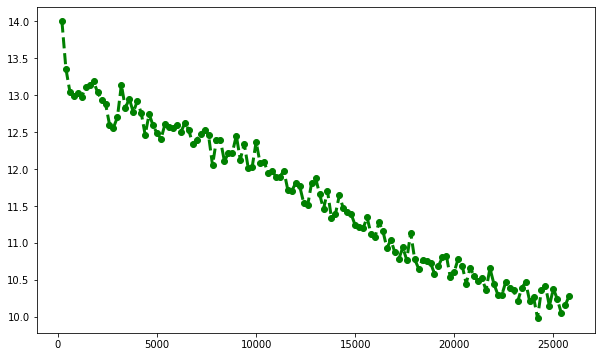

In [ ]:
import matplotlib.pylab as plt
temp = train_reward
del temp[0]
lists = sorted(temp.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='green', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

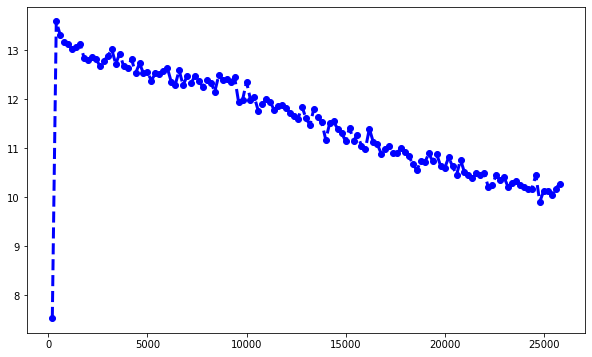

In [ ]:
temp = value
del temp[0]
lists = sorted(temp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='blue', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

In [ ]:
for key, value in actor_loss.items():
  actor_loss[key] = np.absolute(value)
print(actor_loss)

{0: 742.9492, 200: 337.66415, 400: 10.436596, 600: 11.78719, 800: 7.0497518, 1000: 4.146527, 1200: 1.4602808, 1400: 2.7239294, 1600: 0.73265594, 1800: 15.581682, 2000: 11.253682, 2200: 3.2297716, 2400: 3.4184833, 2600: 3.327011, 2800: 8.589441, 3000: 6.0174446, 3200: 5.633027, 3400: 4.6306257, 3600: 1.4554749, 3800: 3.7423906, 4000: 10.8315115, 4200: 2.8700693, 4400: 1.9274129, 4600: 0.71909064, 4800: 3.0460954, 5000: 2.527418, 5200: 1.890962, 5400: 3.7459354, 5600: 3.010373, 5800: 0.55397236, 6000: 0.7641957, 6200: 5.514516, 6400: 12.619115, 6600: 1.6310844, 6800: 2.3368664, 7000: 2.4587014, 7200: 5.813569, 7400: 2.6087036, 7600: 3.9302278, 7800: 6.5207634, 8000: 0.21383893, 8200: 1.7103896, 8400: 1.507278, 8600: 9.221853, 8800: 5.8060927, 9000: 2.3323712, 9200: 7.0465612, 9400: 2.295496, 9600: 2.8587804, 9800: 3.4744349, 10000: 0.7664125, 10200: 3.8477812, 10400: 2.402702, 10600: 7.9031124, 10800: 3.447847, 11000: 2.1840105, 11200: 1.0100303, 11400: 8.269014, 11600: 3.7845714, 11800:

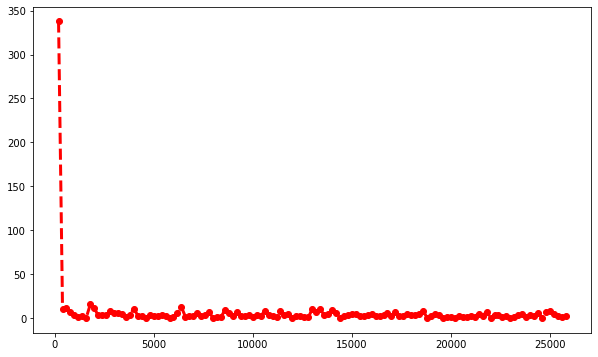

In [ ]:
temp = actor_loss
del temp[0]
lists = sorted(temp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='red', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

In [ ]:
temp

{200: 337.66415,
 400: 10.436596,
 600: 11.78719,
 800: 7.0497518,
 1000: 4.146527,
 1200: 1.4602808,
 1400: 2.7239294,
 1600: 0.73265594,
 1800: 15.581682,
 2000: 11.253682,
 2200: 3.2297716,
 2400: 3.4184833,
 2600: 3.327011,
 2800: 8.589441,
 3000: 6.0174446,
 3200: 5.633027,
 3400: 4.6306257,
 3600: 1.4554749,
 3800: 3.7423906,
 4000: 10.8315115,
 4200: 2.8700693,
 4400: 1.9274129,
 4600: 0.71909064,
 4800: 3.0460954,
 5000: 2.527418,
 5200: 1.890962,
 5400: 3.7459354,
 5600: 3.010373,
 5800: 0.55397236,
 6000: 0.7641957,
 6200: 5.514516,
 6400: 12.619115,
 6600: 1.6310844,
 6800: 2.3368664,
 7000: 2.4587014,
 7200: 5.813569,
 7400: 2.6087036,
 7600: 3.9302278,
 7800: 6.5207634,
 8000: 0.21383893,
 8200: 1.7103896,
 8400: 1.507278,
 8600: 9.221853,
 8800: 5.8060927,
 9000: 2.3323712,
 9200: 7.0465612,
 9400: 2.295496,
 9600: 2.8587804,
 9800: 3.4744349,
 10000: 0.7664125,
 10200: 3.8477812,
 10400: 2.402702,
 10600: 7.9031124,
 10800: 3.447847,
 11000: 2.1840105,
 11200: 1.0100303,

In [ ]:
actor_loss

{200: 337.66415,
 400: 10.436596,
 600: 11.78719,
 800: 7.0497518,
 1000: 4.146527,
 1200: 1.4602808,
 1400: 2.7239294,
 1600: 0.73265594,
 1800: 15.581682,
 2000: 11.253682,
 2200: 3.2297716,
 2400: 3.4184833,
 2600: 3.327011,
 2800: 8.589441,
 3000: 6.0174446,
 3200: 5.633027,
 3400: 4.6306257,
 3600: 1.4554749,
 3800: 3.7423906,
 4000: 10.8315115,
 4200: 2.8700693,
 4400: 1.9274129,
 4600: 0.71909064,
 4800: 3.0460954,
 5000: 2.527418,
 5200: 1.890962,
 5400: 3.7459354,
 5600: 3.010373,
 5800: 0.55397236,
 6000: 0.7641957,
 6200: 5.514516,
 6400: 12.619115,
 6600: 1.6310844,
 6800: 2.3368664,
 7000: 2.4587014,
 7200: 5.813569,
 7400: 2.6087036,
 7600: 3.9302278,
 7800: 6.5207634,
 8000: 0.21383893,
 8200: 1.7103896,
 8400: 1.507278,
 8600: 9.221853,
 8800: 5.8060927,
 9000: 2.3323712,
 9200: 7.0465612,
 9400: 2.295496,
 9600: 2.8587804,
 9800: 3.4744349,
 10000: 0.7664125,
 10200: 3.8477812,
 10400: 2.402702,
 10600: 7.9031124,
 10800: 3.447847,
 11000: 2.1840105,
 11200: 1.0100303,

In [ ]:
for key, value in critic_loss.items():
  critic_loss[key] = np.absolute(value)

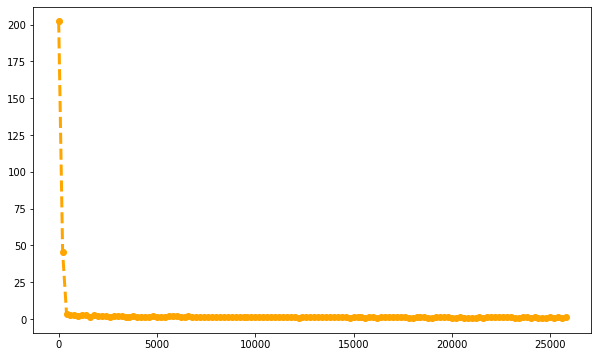

In [ ]:
lists = sorted(critic_loss.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='orange', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

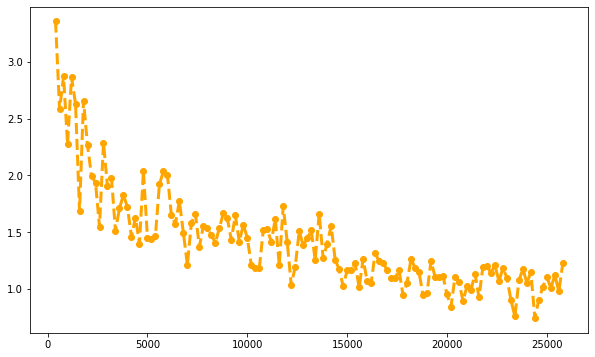

In [ ]:
temp_2 = critic_loss
del temp_2[0]
del temp_2[200]
lists = sorted(temp_2.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='orange', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

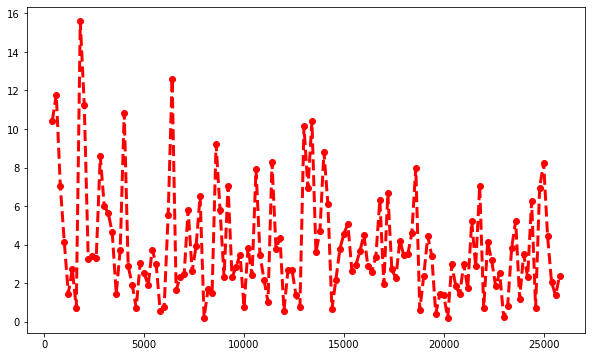

In [ ]:
temp_1 = actor_loss
#del temp_1[0]
del temp_1[200]
lists = sorted(temp_1.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y,color='red', linestyle='dashed', linewidth = 3,
         marker='o')
plt.show()

# change is train to false in parseparams

In [ ]:
import argparse
import os
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
import time




def load_task_specific_components(task):
  
  # This function load task-specific libraries

  if task == 'tsp':
      from TSP.tsp_utils import DataGenerator, Env ,reward_func
      from shared.attention import Attention

      AttentionActor = Attention
      AttentionCritic = Attention


  elif task == 'vrp':
      #from VRP.vrp_utils import DataGenerator,Env,reward_func
      #from VRP.vrp_attention import AttentionVRPActor,AttentionVRPCritic

      AttentionActor = AttentionVRPActor
      AttentionCritic = AttentionVRPCritic

  else:
      raise Exception('Task is not implemented')


  return DataGenerator, Env, reward_func, AttentionActor, AttentionCritic
  

def main(args, prt):
  config = tf.compat.v1.ConfigProto(
                  log_device_placement=True,
                  allow_soft_placement=True)
  config.gpu_options.allow_growth = True
  sess = tf.compat.v1.Session(config=config)


  dataGen = DataGenerator(args)
  dataGen.reset()
  env = Env(args)
  AttentionActor = AttentionVRPActor
  AttentionCritic = AttentionVRPCritic
  # create an RL agent
  agent = RLAgent(args,
                  prt,
                  env,
                  dataGen,
                  reward_func,
                  AttentionActor,
                  AttentionCritic,
                  is_train=args['is_train'])
  agent.Initialize(sess)
  train_reward = {}
  value = {}
  actor_loss = {}
  critic_loss = {}
  # train or evaluate
  start_time = time.time()
  if args['is_train']:
      prt.print_out('Training started ...')
      train_time_beg = time.time()
      for step in range(args['n_train']):
          summary = agent.run_train_step()
          _, _ , actor_loss_val, critic_loss_val, actor_gra_and_var_val, critic_gra_and_var_val,\
              R_val, v_val, logprobs_val,probs_val, actions_val, idxs_val= summary

          if step%args['save_interval'] == 0:
              agent.saver.save(sess,args['model_dir']+'/model.ckpt', global_step=step)

          if step%args['log_interval'] == 0:
              train_time_end = time.time()-train_time_beg
              prt.print_out('Train Step: {} -- Time: {} -- Train reward: {} -- Value: {}'\
                    .format(step,time.strftime("%H:%M:%S", time.gmtime(\
                      train_time_end)),np.mean(R_val),np.mean(v_val)))
              train_reward[step] = np.mean(R_val)
              value[step] = np.mean(v_val)
              prt.print_out('    actor loss: {} -- critic loss: {}'\
                    .format(np.mean(actor_loss_val),np.mean(critic_loss_val)))
              actor_loss[step] = actor_loss_val
              critic_loss[step] = critic_loss_val
              train_time_beg = time.time()
          if step%args['test_interval'] == 0:
              agent.inference(args['infer_type'])

  else: # inference
      prt.print_out('Evaluation started ...')
      agent.inference(args['infer_type'])


  prt.print_out('Total time is {}'.format(\
      time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))))
  return train_reward, value, actor_loss, critic_loss
train_reward = {}
value = {}
actor_loss = {}
critic_loss = {}

if __name__ == "__main__":
  args, prt = ParseParams()
  # Random
  random_seed = args['random_seed']
  if random_seed is not None and random_seed > 0:
      prt.print_out("# Set random seed to %d" % random_seed)
      np.random.seed(random_seed)
      tf.compat.v1.set_random_seed(random_seed)
  tf.compat.v1.reset_default_graph()

  train_reward, value, actor_loss, critic_loss = main(args, prt)

actor_net_lr: 0.0001
agent_type: attention
batch_size: 128
beam_width: 10
capacity: 30
critic_net_lr: 0.0001
data_dir: data
decode_len: 30
demand_max: 9
disable_tqdm: True
dropout: 0.1
embedding_dim: 128
entropy_coeff: 0.1
forget_bias: 1.0
gpu: 1
hidden_dim: 128
infer_type: batch
input_dim: 3
is_train: False
load_path: 
log_dir: logs/vrp20-2021-11-22_16-59-09
log_interval: 200
mask_glimpses: True
mask_pointer: True
max_grad_norm: 2.0
model_dir: logs/vrp10-2021-11-22_04-20-42/model
n_cust: 20
n_glimpses: 0
n_nodes: 21
n_process_blocks: 3
n_train: 26000
random_seed: 24601
rnn_layers: 1
save_interval: 2000
stdout_print: True
tanh_exploration: 10.0
task: vrp20
task_name: vrp
test_interval: 200
test_size: 20
use_tanh: False
# Set random seed to 24601
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Created train iterator.
Loading dataset for vrp-size-20-len-21-test.txt...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


It took 13.371814012527466s to build the agent.
Evaluation started ...
Average of greedy in batch-mode: 12.634183883666992 -- std 1.3527377843856812 -- time 4.065783262252808 s
Average of beam_search in batch-mode: 12.547656059265137 -- std 1.4386858940124512 -- time 5.069460153579712 s
##################################################################
Total time is 00:00:09
